http://www.cs.toronto.edu/~tijmen/affNIST/

In [1]:
from lib import load_batch
b = load_batch(1)

Using TensorFlow backend.


In [2]:
b.image[0].shape

(40, 40)

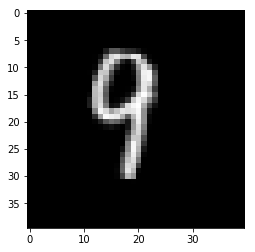

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.imshow(b.image[5], cmap='gray')

In [4]:
image = b.image.reshape(-1, 40, 40, 1)

In [5]:
from sklearn.model_selection import train_test_split

d = train_test_split(image, b.label_one_of_n, test_size=0.1, random_state=42)

In [ ]:
from keras.metrics import categorical_accuracy
import tensorflow
# _, test_x, _, test_y = d
test_x, _, test_y, _ = d
test_x, test_y = test_x[0:1000], test_y[0:1000]
pred_y = model.predict(test_x)
with tensorflow.Session():
    acc = categorical_accuracy(tensorflow.convert_to_tensor(test_y), tensorflow.convert_to_tensor(pred_y)).eval()
print(acc)

In [ ]:
print(test_y[3])
print(pred_y[3])

In [ ]:
from numpy import loadtxt
test = loadtxt("data/test-head.csv", skiprows=1, delimiter=',')

In [ ]:
test[4]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.imshow(test[4, 1:].reshape(40, 40), cmap='gray')

In [ ]:
plt.imshow(b.image[3], cmap='gray')



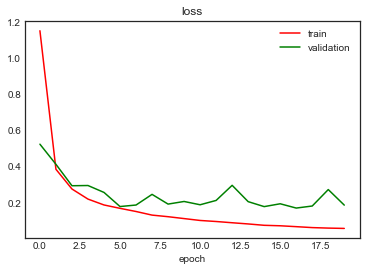

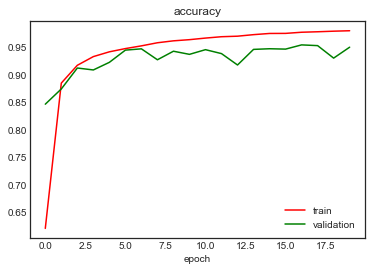

In [16]:
%matplotlib inline


import json
import numpy
from matplotlib import pyplot as plt
with open("my_hist.json") as f:
    hist = json.load(f)
plt.style.use('seaborn-white')
    
axis = numpy.arange(0, len(hist['val_categorical_accuracy']), 1)

plt.figure(1)
plt.title("loss")
plt.plot(axis, hist['loss'], 'r', label='train')
plt.plot(axis, hist['val_loss'], 'g', label='validation')
plt.xlabel("epoch")
plt.legend() # loc='lower center', bbox_to_anchor=(1, 0))


plt.figure(2)
plt.title("accuracy")
plt.plot(axis, hist['categorical_accuracy'], 'r', label='train')
plt.plot(axis, hist['val_categorical_accuracy'], 'g', label='validation')
plt.xlabel("epoch")
plt.legend()

In [19]:
print("Final validation loss:", hist["val_loss"][-1])
print("Final validation accuracy", hist["val_categorical_accuracy"][-1])

Final validation loss: 0.18771210621421536
Final validation accuracy 0.9501666666666667


In [21]:
from keras.models import load_model
model = load_model("my_model.h5")

In [40]:
print(model.flattened_layers[3])
print(model.flattened_layers[3].get_weights())

[]


In [41]:
from keras.models import Sequential

In [80]:
new_model = Sequential()
for l in model.flattened_layers[:10]:
    new_model.add(l)
new_model.compile(loss='categorical_crossentropy', optimizer='sgd')

In [81]:
out = new_model.predict(image[0:100])


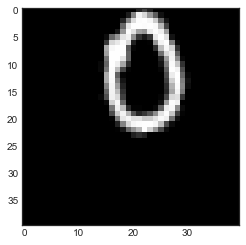

In [84]:
plt.imshow(image[0, :, :, 0], cmap='gray')


(100, 5, 5, 32)


/Users/michal/.virtualenvs/ml1617/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


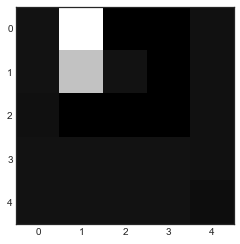

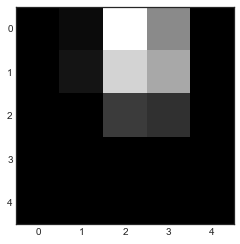

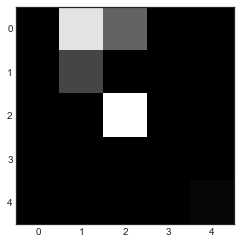

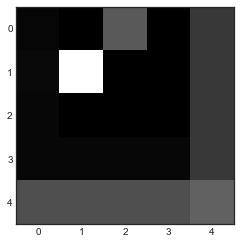

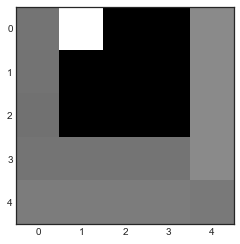

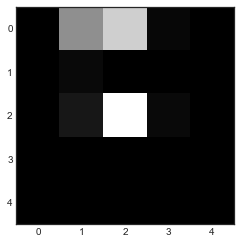

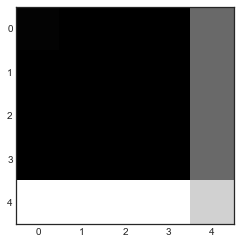

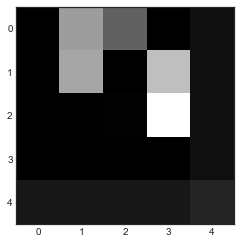

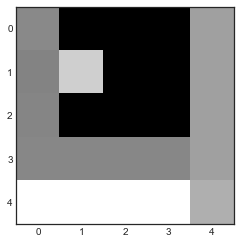

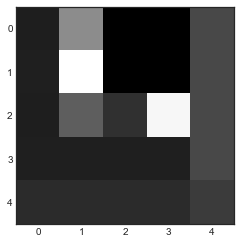

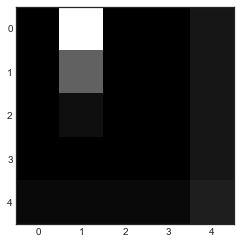

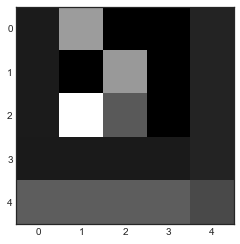

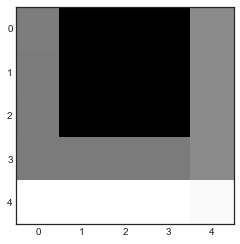

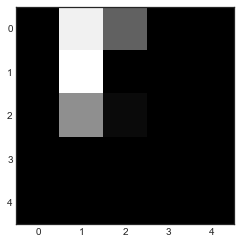

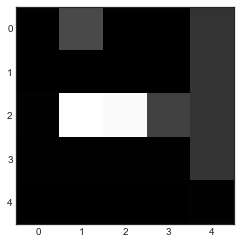

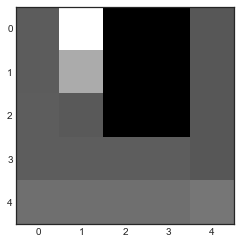

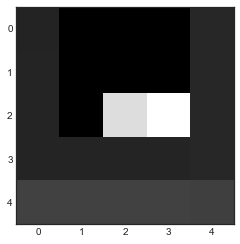

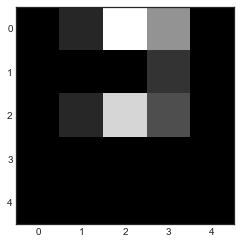

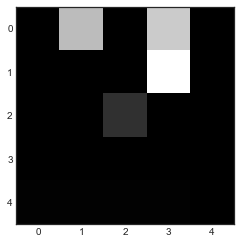

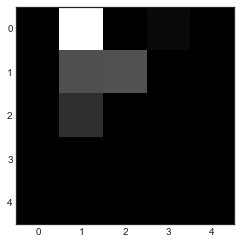

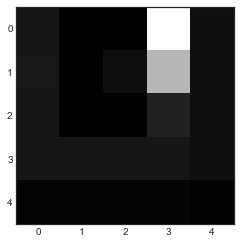

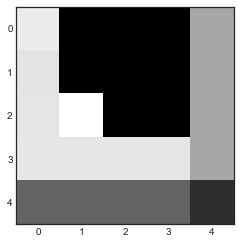

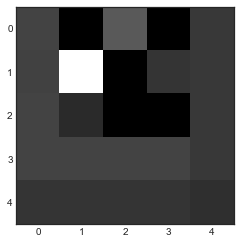

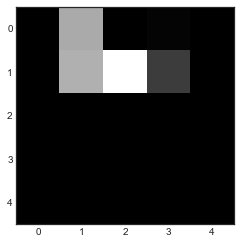

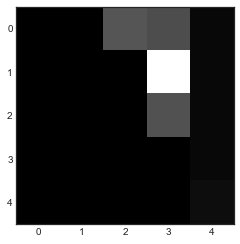

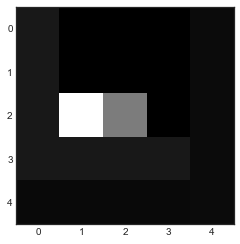

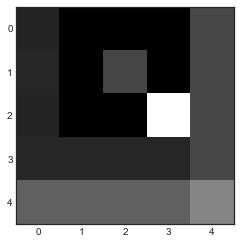

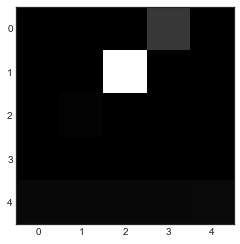

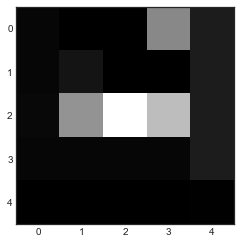

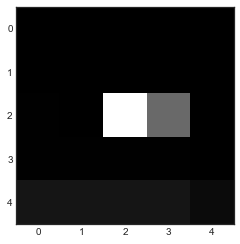

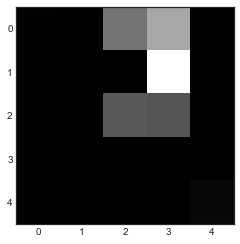

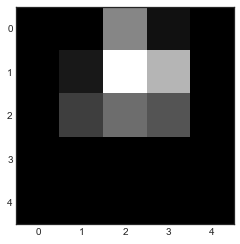

In [85]:
print(out.shape)
for t in range(0, out.shape[3]):
    plt.figure()
    plt.imshow(out[0, :, :, t], cmap='gray')